In [2]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.regularizers import l2
from keras import backend as K
import tensorflow_hub as hub
import h5py

K.set_image_data_format('channels_first')
weights_path = '/content/inception_v1_weights/googlenet_weights.h5'

In [3]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
labels = np.loadtxt('synset_words.txt', str, delimiter='\t')

16384/10484 [==============================================] - 0s 0us/step


---
#**INCEPTION MODEL**

---



In [72]:
class LRN(keras.layers.Layer):

    def __init__(self, alpha=0.0001, k=1, beta=0.75, n=5, **kwargs):
        self.alpha = alpha
        self.k = k
        self.beta = beta
        self.n = n
        super(LRN, self).__init__(**kwargs)

    def call(self, x, mask=None):
        b, ch, r, c = x.shape
        half_n = self.n // 2 # half the local region
        input_sqr = K.square(x) # square the input
        if K.backend() == 'theano':
            # make an empty tensor with zero pads along channel dimension
            zeros = T.alloc(0., b, ch + 2*half_n, r, c)
            # set the center to be the squared input
            input_sqr = T.set_subtensor(zeros[:, half_n:half_n+ch, :, :], input_sqr)
        else:
            input_sqr = tf.pad(input_sqr, [[0, 0], [half_n, half_n], [0, 0], [0, 0]])
        scale = self.k # offset for the scale
        norm_alpha = self.alpha / self.n # normalized alpha
        for i in range(self.n):
            scale += norm_alpha * input_sqr[:, i:i+ch, :, :]
        scale = scale ** self.beta
        x = x / scale
        return x

    def get_config(self):
        config = {"alpha": self.alpha,
                  "k": self.k,
                  "beta": self.beta,
                  "n": self.n}
        base_config = super(LRN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [303]:
# if K.image_data_format() == 'channels_first':
#   channel_axis = 1
# else:
#   channel_axis = 3
channel_axis = 1
K.set_image_data_format('channels_first')

input = keras.Input(shape=(3, 224, 224))

x = layers.ZeroPadding2D(padding=(3,3))(input)

x = layers.Conv2D(64, (7,7), strides=(2,2), padding='valid', activation='relu', name='conv2d0', kernel_regularizer=l2(0.0002))(x)
# x = layers.ZeroPadding2D(padding=(1,1))(x)
# x = PoolHelper()(x)
x = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='maxpool2d0')(x)
x = LRN(name='lrn0')(x)

x = layers.Conv2D(64, (1,1), strides=(1,1), padding='valid', activation='relu', name='conv2d1', kernel_regularizer=l2(0.0002))(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = layers.Conv2D(192, (3,3), strides=(1,1), padding='valid', activation='relu', name='conv2d2', kernel_regularizer=l2(0.0002))(x)
x = LRN(name='lrn1')(x)
# x = layers.ZeroPadding2D(padding=(1,1))(x)
# x = PoolHelper()(x)
x = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='maxpool2d1')(x)

# Inception module 3a
branch1x1 = layers.Conv2D(64, (1,1), strides=(1,1), padding='valid', activation='relu', name='3a1x1', kernel_regularizer=l2(0.0002))(x)
branch3x3 = layers.Conv2D(96, (1,1), strides=(1,1), padding='valid', activation='relu', name='3a3x3reduce', kernel_regularizer=l2(0.0002))(x)
branch3x3 = layers.ZeroPadding2D(padding=(1, 1))(branch3x3)
branch3x3 = layers.Conv2D(128, (3,3), strides=(1,1), padding='valid', activation='relu', name='3a3x3', kernel_regularizer=l2(0.0002))(branch3x3)
branch5x5 = layers.Conv2D(16, (1,1), strides=(1,1), padding='valid', activation='relu', name='3a5x5reduce', kernel_regularizer=l2(0.0002))(x)
branch5x5 = layers.ZeroPadding2D(padding=(2, 2))(branch5x5)
branch5x5 = layers.Conv2D(32, (5,5), strides=(1,1), padding='valid', activation='relu', name='3a5x5', kernel_regularizer=l2(0.0002))(branch5x5)
branch_pool = layers.MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='3amaxpool')(x)
branch_pool = layers.Conv2D(32, (1,1), strides=(1,1), padding='valid', activation='relu', name='3apool1x1', kernel_regularizer=l2(0.0002))(branch_pool)
x = layers.Concatenate(axis=channel_axis, name="mixed3a")([branch1x1, branch3x3, branch5x5, branch_pool])

# Inception module 3b
branch1x1 = layers.Conv2D(128, (1,1), strides=(1,1), padding='valid', activation='relu', name='3b1x1', kernel_regularizer=l2(0.0002))(x)
branch3x3 = layers.Conv2D(128, (1,1), strides=(1,1), padding='valid', activation='relu', name='3b3x3reduce', kernel_regularizer=l2(0.0002))(x)
branch3x3 = layers.ZeroPadding2D(padding=(1, 1))(branch3x3)
branch3x3 = layers.Conv2D(192, (3,3), strides=(1,1), padding='valid', activation='relu', name='3b3x3', kernel_regularizer=l2(0.0002))(branch3x3)
branch5x5 = layers.Conv2D(32, (1,1), strides=(1,1), padding='valid', activation='relu', name='3b5x5reduce', kernel_regularizer=l2(0.0002))(x)
branch5x5 = layers.ZeroPadding2D(padding=(2, 2))(branch5x5)
branch5x5 = layers.Conv2D(96, (5,5), strides=(1,1), padding='valid', activation='relu', name='3b5x5', kernel_regularizer=l2(0.0002))(branch5x5)
branch_pool = layers.MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='3bmaxpool')(x)
branch_pool = layers.Conv2D(64, (1,1), strides=(1,1), padding='valid', activation='relu', name='3bpool1x1', kernel_regularizer=l2(0.0002))(branch_pool)
x = layers.Concatenate(axis=channel_axis, name="mixed3b")([branch1x1, branch3x3, branch5x5, branch_pool])

# x = layers.ZeroPadding2D(padding=(1, 1))(x)
# x = PoolHelper()(x)
x = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same', name='maxpool2d2')(x)

# Inception module 4a
branch1x1 = layers.Conv2D(192, (1,1), strides=(1,1), padding='valid', activation='relu', name='4a1x1', kernel_regularizer=l2(0.0002))(x)
branch3x3 = layers.Conv2D(96, (1,1), strides=(1,1), padding='valid', activation='relu', name='4a3x3reduce', kernel_regularizer=l2(0.0002))(x)
branch3x3 = layers.ZeroPadding2D(padding=(1, 1))(branch3x3)
branch3x3 = layers.Conv2D(208, (3,3), strides=(1,1), padding='valid', activation='relu', name='4a3x3', kernel_regularizer=l2(0.0002))(branch3x3)
branch5x5 = layers.Conv2D(16, (1,1), strides=(1,1), padding='valid', activation='relu', name='4a5x5reduce', kernel_regularizer=l2(0.0002))(x)
branch5x5 = layers.ZeroPadding2D(padding=(2, 2))(branch5x5)
branch5x5 = layers.Conv2D(48, (5,5), strides=(1,1), padding='valid', activation='relu', name='4a5x5', kernel_regularizer=l2(0.0002))(branch5x5)
branch_pool = layers.MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='4amaxpool')(x)
branch_pool = layers.Conv2D(64, (1,1), strides=(1,1), padding='valid', activation='relu', name='4apool1x1', kernel_regularizer=l2(0.0002))(branch_pool)
x = layers.Concatenate(axis=channel_axis, name="mixed4a")([branch1x1, branch3x3, branch5x5, branch_pool])

# Auxiliary classifier 1
loss1_ave_pool = layers.AveragePooling2D(pool_size=(5,5), strides=(3,3), name='loss1/avg_pool')(x)
loss1_conv = layers.Conv2D(128, (1,1), padding='valid', activation='relu', name='loss1/conv', kernel_regularizer=l2(0.0002))(loss1_ave_pool)
loss1_flat = layers.Flatten()(loss1_conv)
loss1_fc = layers.Dense(1024, activation='relu', name='loss1/fc', kernel_regularizer=l2(0.0002))(loss1_flat)
loss1_drop_fc = layers.Dropout(rate=0.7)(loss1_fc)
loss1_classifier = layers.Dense(1000, name='loss1/classifier', kernel_regularizer=l2(0.0002))(loss1_drop_fc)
loss1_classifier_act = layers.Activation('softmax')(loss1_classifier)

# Inception module 4b
branch1x1 = layers.Conv2D(160, (1,1), strides=(1,1), padding='valid', activation='relu', name='4b1x1', kernel_regularizer=l2(0.0002))(x)
branch3x3 = layers.Conv2D(112, (1,1), strides=(1,1), padding='valid', activation='relu', name='4b3x3reduce', kernel_regularizer=l2(0.0002))(x)
branch3x3 = layers.ZeroPadding2D(padding=(1, 1))(branch3x3)
branch3x3 = layers.Conv2D(224, (3,3), strides=(1,1), padding='valid', activation='relu', name='4b3x3', kernel_regularizer=l2(0.0002))(branch3x3)
branch5x5 = layers.Conv2D(24, (1,1), strides=(1,1), padding='valid', activation='relu', name='4b5x5reduce', kernel_regularizer=l2(0.0002))(x)
branch5x5 = layers.ZeroPadding2D(padding=(2, 2))(branch5x5)
branch5x5 = layers.Conv2D(64, (5,5), strides=(1,1), padding='valid', activation='relu', name='4b5x5', kernel_regularizer=l2(0.0002))(branch5x5)
branch_pool = layers.MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='4bmaxpool')(x)
branch_pool = layers.Conv2D(64, (1,1), strides=(1,1), padding='valid', activation='relu', name='4bpool1x1', kernel_regularizer=l2(0.0002))(branch_pool)
x = layers.Concatenate(axis=channel_axis, name="mixed4b")([branch1x1, branch3x3, branch5x5, branch_pool])

# Inception module 4c
branch1x1 = layers.Conv2D(128, (1,1), strides=(1,1), padding='valid', activation='relu', name='4c1x1', kernel_regularizer=l2(0.0002))(x)
branch3x3 = layers.Conv2D(128, (1,1), strides=(1,1), padding='valid', activation='relu', name='4c3x3reduce', kernel_regularizer=l2(0.000))(x)
branch3x3 = layers.ZeroPadding2D(padding=(1, 1))(branch3x3)
branch3x3 = layers.Conv2D(256, (3,3), strides=(1,1), padding='valid', activation='relu', name='4c3x3', kernel_regularizer=l2(0.0002))(branch3x3)
branch5x5 = layers.Conv2D(24, (1,1), strides=(1,1), padding='valid', activation='relu', name='4c5x5reduce', kernel_regularizer=l2(0.0002))(x)
branch5x5 = layers.ZeroPadding2D(padding=(2, 2))(branch5x5)
branch5x5 = layers.Conv2D(64, (5,5), strides=(1,1), padding='valid', activation='relu', name='4c5x5', kernel_regularizer=l2(0.0002))(branch5x5)
branch_pool = layers.MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='4cmaxpool')(x)
branch_pool = layers.Conv2D(64, (1,1), strides=(1,1), padding='valid', activation='relu', name='4cpool1x1', kernel_regularizer=l2(0.0002))(branch_pool)
x = layers.Concatenate(axis=channel_axis, name="mixed4c")([branch1x1, branch3x3, branch5x5, branch_pool])

# Inception module 4d
branch1x1 = layers.Conv2D(112, (1,1), strides=(1,1), padding='valid', activation='relu', name='4d1x1', kernel_regularizer=l2(0.0002))(x)
branch3x3 = layers.Conv2D(144, (1,1), strides=(1,1), padding='valid', activation='relu', name='4d3x3reduce', kernel_regularizer=l2(0.0002))(x)
branch3x3 = layers.ZeroPadding2D(padding=(1, 1))(branch3x3)
branch3x3 = layers.Conv2D(288, (3,3), strides=(1,1), padding='valid', activation='relu', name='4d3x3', kernel_regularizer=l2(0.0002))(branch3x3)
branch5x5 = layers.Conv2D(32, (1,1), strides=(1,1), padding='valid', activation='relu', name='4d5x5reduce', kernel_regularizer=l2(0.0002))(x)
branch5x5 = layers.ZeroPadding2D(padding=(2, 2))(branch5x5)
branch5x5 = layers.Conv2D(64, (5,5), strides=(1,1), padding='valid', activation='relu', name='4d5x5', kernel_regularizer=l2(0.0002))(branch5x5)
branch_pool = layers.MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='4dmaxpool')(x)
branch_pool = layers.Conv2D(64, (1,1), strides=(1,1), padding='valid', activation='relu', name='4dpool1x1', kernel_regularizer=l2(0.0002))(branch_pool)
x = layers.Concatenate(axis=channel_axis, name="mixed4d")([branch1x1, branch3x3, branch5x5, branch_pool])

# Auxiliary classifier 2
loss2_ave_pool = layers.AveragePooling2D(pool_size=(5,5), strides=(3,3), name='loss2/ave_pool')(x)
loss2_conv = layers.Conv2D(128, (1,1), padding='valid', activation='relu', name='loss2/conv', kernel_regularizer=l2(0.0002))(loss2_ave_pool)
loss2_flat = layers.Flatten()(loss2_conv)
loss2_fc = layers.Dense(1024, activation='relu', name='loss2/fc', kernel_regularizer=l2(0.0002))(loss2_flat)
loss2_drop_fc = layers.Dropout(rate=0.7)(loss2_fc)
loss2_classifier = layers.Dense(1000, name='loss2/classifier', kernel_regularizer=l2(0.0002))(loss2_drop_fc)
loss2_classifier_act = layers.Activation('softmax')(loss2_classifier)

# Inception module 4e
branch1x1 = layers.Conv2D(256, (1,1), strides=(1,1), padding='valid', activation='relu', name='4e1x1', kernel_regularizer=l2(0.0002))(x)
branch3x3 = layers.Conv2D(160, (1,1), strides=(1,1), padding='valid', activation='relu', name='4e3x3reduce', kernel_regularizer=l2(0.0002))(x)
branch3x3 = layers.ZeroPadding2D(padding=(1, 1))(branch3x3)
branch3x3 = layers.Conv2D(320, (3,3), strides=(1,1), padding='valid', activation='relu', name='4e3x3', kernel_regularizer=l2(0.0002))(branch3x3)
branch5x5 = layers.Conv2D(32, (1,1), strides=(1,1), padding='valid', activation='relu', name='4e5x5reduce', kernel_regularizer=l2(0.0002))(x)
branch5x5 = layers.ZeroPadding2D(padding=(2, 2))(branch5x5)
branch5x5 = layers.Conv2D(128, (5,5), strides=(1,1), padding='valid', activation='relu', name='4e5x5', kernel_regularizer=l2(0.0002))(branch5x5)
branch_pool = layers.MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='4emaxpool')(x)
branch_pool = layers.Conv2D(128, (1,1), strides=(1,1), padding='valid', activation='relu', name='4epool1x1', kernel_regularizer=l2(0.0002))(branch_pool)
x = layers.Concatenate(axis=channel_axis, name="mixed4e")([branch1x1, branch3x3, branch5x5, branch_pool])

# x = layers.ZeroPadding2D(padding=(1, 1))(x)
# x = PoolHelper()(x)
x = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same', name='maxpool2d3')(x)

# Inception module 5a
branch1x1 = layers.Conv2D(256, (1,1), strides=(1,1), padding='valid', activation='relu', name='5a1x1', kernel_regularizer=l2(0.0002))(x)
branch3x3 = layers.Conv2D(160, (1,1), strides=(1,1), padding='valid', activation='relu', name='5a3x3reduce', kernel_regularizer=l2(0.0002))(x)
branch3x3 = layers.ZeroPadding2D(padding=(1, 1))(branch3x3)
branch3x3 = layers.Conv2D(320, (3,3), strides=(1,1), padding='valid', activation='relu', name='5a3x3', kernel_regularizer=l2(0.0002))(branch3x3)
branch5x5 = layers.Conv2D(32, (1,1), strides=(1,1), padding='valid', activation='relu', name='5a5x5reduce', kernel_regularizer=l2(0.0002))(x)
branch5x5 = layers.ZeroPadding2D(padding=(2, 2))(branch5x5)
branch5x5 = layers.Conv2D(128, (5,5), strides=(1,1), padding='valid', activation='relu', name='5a5x5', kernel_regularizer=l2(0.0002))(branch5x5)
branch_pool = layers.MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='5amaxpool')(x)
branch_pool = layers.Conv2D(128, (1,1), strides=(1,1), padding='valid', activation='relu', name='5apool1x1', kernel_regularizer=l2(0.0002))(branch_pool)
x = layers.Concatenate(axis=channel_axis, name="mixed5a")([branch1x1, branch3x3, branch5x5, branch_pool])

# Inception module 5b
branch1x1 = layers.Conv2D(384, (1,1), strides=(1,1), padding='valid', activation='relu', name='5b1x1', kernel_regularizer=l2(0.0002))(x)
branch3x3 = layers.Conv2D(192, (1,1), strides=(1,1), padding='valid', activation='relu', name='5b3x3reduce', kernel_regularizer=l2(0.0002))(x)
branch3x3 = layers.ZeroPadding2D(padding=(1, 1))(branch3x3)
branch3x3 = layers.Conv2D(384, (3,3), strides=(1,1), padding='valid', activation='relu', name='5b3x3', kernel_regularizer=l2(0.0002))(branch3x3)
branch5x5 = layers.Conv2D(48, (1,1), strides=(1,1), padding='valid', activation='relu', name='5b5x5reduce', kernel_regularizer=l2(0.0002))(x)
branch5x5 = layers.ZeroPadding2D(padding=(2, 2))(branch5x5)
branch5x5 = layers.Conv2D(128, (5,5), strides=(1,1), padding='valid', activation='relu', name='5b5x5', kernel_regularizer=l2(0.0002))(branch5x5)
branch_pool = layers.MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='5bmaxpool')(x)
branch_pool = layers.Conv2D(128, (1,1), strides=(1,1), padding='valid', activation='relu', name='5bpool1x1', kernel_regularizer=l2(0.0002))(branch_pool)
x = layers.Concatenate(axis=channel_axis, name="mixed5b")([branch1x1, branch3x3, branch5x5, branch_pool])

x = layers.AveragePooling2D(pool_size=(7,7), strides=(1,1), name='avgpool2d0')(x)
x = layers.Flatten(name="flat1")(x)
x = layers.Dropout(rate=0.4, name="dropout_final")(x)
x = layers.Dense(1000, name='classifier', kernel_regularizer=l2(0.0002))(x)
x = layers.Activation('softmax', name='prob')(x)

model = keras.Model(inputs=input, outputs=[loss1_classifier_act, loss2_classifier_act, x])
# sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(optimizer=sgd, loss='categorical_crossentropy')
# keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)

In [304]:
model.load_weights(weights_path)

In [317]:
IMAGE_SHAPE = (224, 224)
img_o = Image.open('puppy.jpg').resize(IMAGE_SHAPE)
img = np.array(img_o).astype(np.float32)
img[:, :, 0] -= 123.68
img[:, :, 1] -= 116.779
img[:, :, 2] -= 103.939
img[:,:,[0,1,2]] = img[:,:,[2,1,0]]
img = tf.transpose(img, (2, 0, 1))
img = tf.expand_dims(img, axis=0)
img.shape

TensorShape([1, 3, 224, 224])

Text(0.5, 1.0, 'Prediction: Curly-Coated Retriever | n02099601 golden retriever')

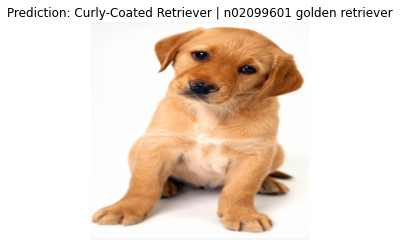

In [320]:
res = model.predict(img)
predicted_class = np.argmax(res[2][0], axis=-1)
plt.imshow(img_o)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
predicted_label = labels[predicted_class]
plt.title("Prediction: " + predicted_class_name.title() + " | " + predicted_label)

# **Load weight**
#### These methods are from the keras library... in case you want to try loading weight manually

In [7]:
def load_attributes_from_hdf5_group(group, name):
  """Loads attributes of the specified name from the HDF5 group.
  This method deals with an inherent problem
  of HDF5 file which is not able to store
  data larger than HDF5_OBJECT_HEADER_LIMIT bytes.
  Arguments:
      group: A pointer to a HDF5 group.
      name: A name of the attributes to load.
  Returns:
      data: Attributes data.
  """
  if name in group.attrs:
    data = [n.decode('utf8') for n in group.attrs[name]]
  else:
    data = []
    chunk_id = 0
    while '%s%d' % (name, chunk_id) in group.attrs:
      data.extend(
          [n.decode('utf8') for n in group.attrs['%s%d' % (name, chunk_id)]])
      chunk_id += 1
  return data

In [8]:
def _legacy_weights(layer):
  """DO NOT USE.
  For legacy reason, the layer.weights was in the order of
  [self.trainable_weights + self.non_trainable_weights], and this order was
  used for preserving the weights in h5 format. The new order of layer.weights
  are the same as layer.get_weights() which is more intuitive for user. To
  keep supporting the existing saved h5 file, this method should be used to
  save/load weights. In future version, we will delete this method and
  introduce a breaking change for h5 and stay with the new order for weights.
  Args:
    layer: a `tf.keras.Model` or `tf.keras.layers.Layer` instance.
  Returns:
    A list of variables with the order of trainable_weights, followed by
      non_trainable_weights.
  """
  weights = layer.trainable_weights + layer.non_trainable_weights
  if any(not isinstance(w, tf.Variable) for w in weights):
    raise NotImplementedError(
        'Save or restore weights that is not an instance of `tf.Variable` is '
        'not supported in h5, use `save_format=\'tf\'` instead. Got a model '
        'or layer {} with weights {}'.format(layer.__class__.__name__, weights))
  return weights

In [15]:
filepath = '/content/inception_v1_weights/googlenet_weights.h5'
opened_new_file = not isinstance(filepath, h5py.File)
if opened_new_file:
  f = h5py.File(filepath, mode='r')
else:
  f = filepath

model_layers = model.layers
filtered_layers = []
for layer in model_layers:
  weights = _legacy_weights(layer)
  if weights:
    filtered_layers.append(layer)
print(filtered_layers)

layer_names = load_attributes_from_hdf5_group(f, 'layer_names')
filtered_layer_names = []
for name in layer_names:
  g = f[name]
  weight_names = load_attributes_from_hdf5_group(g, 'weight_names')
  if weight_names:
    filtered_layer_names.append(name)
print(filtered_layer_names)
layer_names = filtered_layer_names
if len(layer_names) != len(filtered_layers):
    raise ValueError('You are trying to load a weight file '
                     'containing ' + str(len(layer_names)) +
                     ' layers into a model with ' + str(len(filtered_layers)) +
                     ' layers.')

[<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7c1c157208>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7c1c157780>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7c1c2244e0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7c1c22f3c8>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7c1c237ac8>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7c1c2296a0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7c1c22f9b0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7c1c237eb8>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7c1c24d588>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7c1c1dd1d0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7c1c1e6a20>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7c1c25a240>, <tensorflow.python.keras.layers.convolu

In [ ]:
weight_value_tuples = []
for k, name in enumerate(layer_names):
  g = f[name]
  weight_names = load_attributes_from_hdf5_group(g, 'weight_names')
  # print(weight_names)
  weight_values = [np.asarray(g[weight_name]) for weight_name in weight_names]
  layer = filtered_layers[k]
  print(layer.name)
  symbolic_weights = _legacy_weights(layer)
  print("s_w", symbolic_weights[0].shape)
  print("w_v", weight_values[0].shape)

  if layer.__class__.__name__ == 'Conv2D':
    if layer.data_format == 'channels_first':
      # old: (filters, stack_size, kernel_rows, kernel_cols)
      # new: (kernel_rows, kernel_cols, stack_size, filters)
      weight_values[0] = np.transpose(weight_values[0], (2, 3, 1, 0))
  if K.int_shape(layer.weights[0]) != weight_values[0].shape:
    weight_values[0] = np.transpose(weight_values[0], (3, 2, 0, 1))
  
  if len(weight_values) != len(symbolic_weights):
      raise ValueError('Layer #' + str(k) + ' (named "' + layer.name +
                       '" in the current model) was found to '
                       'correspond to layer ' + name + ' in the save file. '
                       'However the new layer ' + layer.name + ' expects ' +
                       str(len(symbolic_weights)) +
                       ' weights, but the saved weights have ' +
                       str(len(weight_values)) + ' elements.')
  weight_value_tuples += zip(symbolic_weights, weight_values)
K.batch_set_value(weight_value_tuples)